# network-level connectivity mat

In [46]:
# load time-series
# average over networks
# make link mat for epochs

In [47]:
import pandas as pd

# in data/ts/ we don't have cerebellum regions included. only 1012 regions.
def timeseries(subject, epoch): return pd.read_csv('data/ts/ts_'+str(subject)+'_'+epoch+'.csv')

regions_networks = pd.read_csv('data/regions_sorted.csv')
regions_networks = regions_networks.set_index('region')[['7net', '17net']]
names_7net = regions_networks['7net'].unique()
names_17net = regions_networks['17net'].unique()

def ts_network(subject, epoch, net='7'):
    ts = timeseries(subject, epoch)
    ts = ts.transpose().join(regions_networks)
    ts = ts.set_index(['7net', '17net'], append=True).reorder_levels([1, 2, 0])
    assert net in ['7', '17']
    return ts.groupby(level=0 if net == '7' else 1).mean().transpose()

import numpy as np
from nilearn.connectome import ConnectivityMeasure

def cmat(ts: pd.DataFrame, fill_diag=False, kind='covariance') -> np.ndarray:
    conn_measure = ConnectivityMeasure(kind=kind)
    cmat = conn_measure.fit_transform([ts.to_numpy()])[0]
    if fill_diag:   np.fill_diagonal(cmat, 0)
    return cmat

In [48]:
pd.DataFrame(cmat(ts_network(subject=2, epoch='baseline', net='7')),
             index=names_7net, columns=names_7net)

,Vis,SomMot,DorsAttn,SalVentAttn,Limbic,Cont,Default,Striatum
Vis,0.201280,0.087966,0.142202,0.049346,0.079667,0.071522,0.027504,0.080598
SomMot,0.087966,0.188305,0.052284,0.091797,0.047771,0.074170,0.071028,0.089921
DorsAttn,0.142202,0.052284,0.248526,0.036092,0.100352,0.087704,0.027520,0.101834
SalVentAttn,0.049346,0.091797,0.036092,0.143583,0.049856,0.055836,0.061911,0.122147
Limbic,0.079667,0.047771,0.100352,0.049856,0.228600,0.189976,0.065869,0.125423
Cont,0.071522,0.074170,0.087704,0.055836,0.189976,0.253876,0.094485,0.170039
Default,0.027504,0.071028,0.027520,0.061911,0.065869,0.094485,0.276849,0.075117
Striatum,0.080598,0.089921,0.101834,0.122147,0.125423,0.170039,0.075117,0.319586


In [49]:
# subjects
DIR = '/Users/qasem/PycharmProjects/cortical-400-subcortical-RL-task-rest/'
subjects = pd.read_csv(DIR + '_participants.tsv', sep='\t')
subjects = subjects.loc[subjects.exclude == 0, 'participant_id'].tolist()
subjects.remove(37)  # no data available
subjects.remove(25)  # no data available
subjects.remove(36)  # no data available
# print(subjects)

In [65]:
cmats = []

for epoch in ['baseline', 'early', 'late']:
    for subject in subjects:
        cm = pd.DataFrame(cmat(ts_network(subject, epoch, net='7')),
                     index=names_7net, columns=names_7net)

        cm['epoch'] = epoch
        cm['subject'] = subject
        cmats.append(cm)

cmats = pd.concat(cmats)

,Vis,SomMot,DorsAttn,SalVentAttn,Limbic,Cont,Default,Striatum,epoch,subject
Vis,0.187525,0.096862,0.043184,0.010085,0.063508,0.006674,0.013514,0.010976,baseline,1
SomMot,0.096862,0.223313,0.014215,0.051531,0.026835,0.070564,0.071801,0.032145,baseline,1
DorsAttn,0.043184,0.014215,0.161627,0.022898,0.078086,0.051372,0.018501,0.051613,baseline,1
SalVentAttn,0.010085,0.051531,0.022898,0.094221,0.019874,0.047160,0.032460,0.007271,baseline,1
Limbic,0.063508,0.026835,0.078086,0.019874,0.172828,0.096678,0.018122,0.093026,baseline,1
...,...,...,...,...,...,...,...,...,...,...
SalVentAttn,0.089955,0.118649,0.100114,0.207117,0.083037,0.096363,0.065316,0.101773,late,46
Limbic,0.184776,0.130593,0.177400,0.083037,0.301095,0.257530,0.135412,0.121269,late,46
Cont,0.146179,0.149032,0.202832,0.096363,0.257530,0.356913,0.126910,0.156252,late,46
Default,0.086419,0.105487,0.048899,0.065316,0.135412,0.126910,0.466855,0.054951,late,46


In [83]:
cmats.set_index(['subject', 'epoch'], append=True, inplace=True)
cmats = cmats.stack()
cmats.index.names = ['from', 'subject', 'epoch', 'to']
cmats = cmats.reorder_levels(['subject', 'epoch', 'from', 'to'])
cmats.name = 'corr'

In [86]:
cmats.shape

(6912,)

In [87]:
cmats.head()

subject  epoch     from  to         
1        baseline  Vis   Vis            0.187525
                         SomMot         0.096862
                         DorsAttn       0.043184
                         SalVentAttn    0.010085
                         Limbic         0.063508
Name: corr, dtype: float64

In [93]:
# average it over all subjects
cmat_mean = cmats.groupby(level=['epoch', 'from', 'to']).mean()

In [119]:
cmat_mean.loc['baseline'].unstack().loc[names_7net] # to sort rows regarding original order

to,Vis,SomMot,DorsAttn,SalVentAttn,Limbic,Cont,Default,Striatum
from,,,,,,,,
Vis,0.171464,0.053365,0.096325,0.031479,0.066521,0.028610,0.024284,0.030081
SomMot,0.053365,0.191701,0.002199,0.092799,0.003188,0.047088,0.044076,0.075519
DorsAttn,0.096325,0.002199,0.233464,0.027094,0.120898,0.101698,0.027401,0.086922
SalVentAttn,0.031479,0.092799,0.027094,0.158192,0.029340,0.055075,0.051550,0.056292
Limbic,0.066521,0.003188,0.120898,0.029340,0.227885,0.146334,0.054744,0.049182
Cont,0.028610,0.047088,0.101698,0.055075,0.146334,0.229789,0.056395,0.091715
Default,0.024284,0.044076,0.027401,0.051550,0.054744,0.056395,0.295583,0.037929
Striatum,0.030081,0.075519,0.086922,0.056292,0.049182,0.091715,0.037929,0.261061


In [ ]:
## make b2e and e2l

there's a subtle mistake here. we're computing the difference between average link values, THOUGH t-stats is the better option. if it comes out to be significant, I'll fix it.

for each link (e.g. DMN to DAN), a pair-wise t-test 'baseline' and 'early' N=36.

In [128]:
## add b2e and e2l to cmats

In [ ]:
cmats = cmats.unstack('epoch')
cmats['b2e'] = cmats['early'] - cmats['baseline']
cmats['e2l'] = cmats['late'] - cmats['early']
cmats = cmats.stack()
cmats = cmats.reorder_levels(['subject', 'epoch', 'from', 'to'])
cmats.name = 'corr'

In [ ]:
# plot heatmaps of cmat
import seaborn
import matplotlib.pyplot as plt

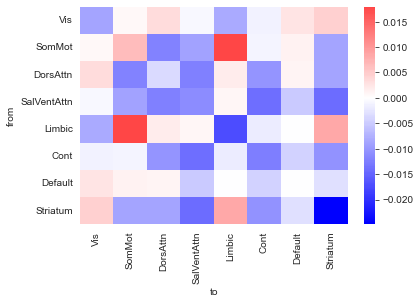

In [142]:
seaborn.heatmap(cmats.groupby(level=['epoch', 'from', 'to']).mean().loc['b2e'].unstack().loc[names_7net],
                cmap='bwr', center=0)
plt.show()

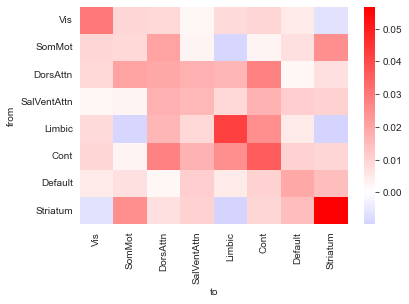

In [143]:
seaborn.heatmap(cmats.groupby(level=['epoch', 'from', 'to']).mean().loc['e2l'].unstack().loc[names_7net],
                cmap='bwr', center=0)
plt.show()

# correlate with score

In [126]:
# load learning scores
metrics = pd.read_csv('data/metrics.csv', index_col=3)
metrics

,Subject,tscore,RLScore
subject,,,
1,AB1,-8.686500,-1.179789
2,AG1,-6.485268,1.104018
3,AH1,-2.347640,-0.302101
4,AM1,-6.676496,-1.400917
6,AP1,-16.480796,0.868475
7,AV1,-3.902501,0.859943
8,BN1,-6.263557,1.433999
9,CD1,-10.370127,-0.661215
10,CG1,-4.442353,-0.337563


In [ ]:
from scipy.stats import pearsonr
def corr_r(df):   return pearsonr(df['corr'], df['RLScore'])[0]
def corr_p(df):   return pearsonr(df['corr'], df['RLScore'])[1]

corr_scores_r = cmats.to_frame().join(metrics).groupby(level=['epoch', 'from', 'to']).apply(corr_r)
corr_scores_p = cmats.to_frame().join(metrics).groupby(level=['epoch', 'from', 'to']).apply(corr_p)

In [195]:
# correlation values
corr_scores_r.unstack('to').loc[pd.IndexSlice[:, names_7net], names_7net]

,to,Vis,SomMot,DorsAttn,SalVentAttn,Limbic,Cont,Default,Striatum
epoch,from,,,,,,,,
baseline,Vis,-0.413065,-0.422095,-0.119582,-0.326551,-0.176408,-0.109729,-0.008925,-0.297490
early,Vis,-0.266143,-0.288579,-0.252106,-0.173849,-0.315632,-0.286088,-0.147132,-0.307373
late,Vis,-0.303128,-0.127954,-0.375644,-0.156283,-0.308589,-0.247603,-0.235963,-0.299434
b2e,Vis,0.133997,0.055055,-0.150266,0.136882,-0.168781,-0.228092,-0.116477,-0.024775
e2l,Vis,-0.087297,0.178051,-0.249033,-0.038737,-0.064306,0.013858,-0.166099,-0.067092
baseline,SomMot,-0.422095,-0.163971,-0.258861,-0.131407,-0.263916,-0.141047,-0.170645,-0.084206
early,SomMot,-0.288579,-0.271392,-0.189421,-0.036302,-0.248612,-0.333113,-0.082005,-0.464910
late,SomMot,-0.127954,0.031732,-0.117541,0.115949,-0.140332,-0.173893,-0.066056,-0.137748
b2e,SomMot,0.055055,-0.134688,0.044311,0.126279,-0.008311,-0.201296,0.071528,-0.292168


In [211]:
# p-values
corr_scores_p.unstack('to').loc[pd.IndexSlice[:, names_7net], names_7net]

,to,Vis,SomMot,DorsAttn,SalVentAttn,Limbic,Cont,Default,Striatum
epoch,from,,,,,,,,
baseline,Vis,0.012285,0.010339,0.487264,0.051918,0.303390,0.524082,0.958797,0.078055
early,Vis,0.116659,0.087842,0.137986,0.310568,0.060763,0.090739,0.391827,0.068215
late,Vis,0.072315,0.457060,0.023963,0.362708,0.067075,0.145400,0.165910,0.076037
b2e,Vis,0.435903,0.749792,0.381704,0.425996,0.325101,0.180906,0.498720,0.885953
e2l,Vis,0.612669,0.298836,0.143016,0.822521,0.709444,0.936066,0.332960,0.697434
baseline,SomMot,0.010339,0.339278,0.127391,0.444903,0.119867,0.411913,0.319709,0.625354
early,SomMot,0.087842,0.109355,0.268523,0.833514,0.143714,0.047117,0.634454,0.004279
late,SomMot,0.457060,0.854233,0.494779,0.500679,0.414314,0.310445,0.701894,0.423046
b2e,SomMot,0.749792,0.433519,0.797481,0.463021,0.961629,0.239095,0.678470,0.083792


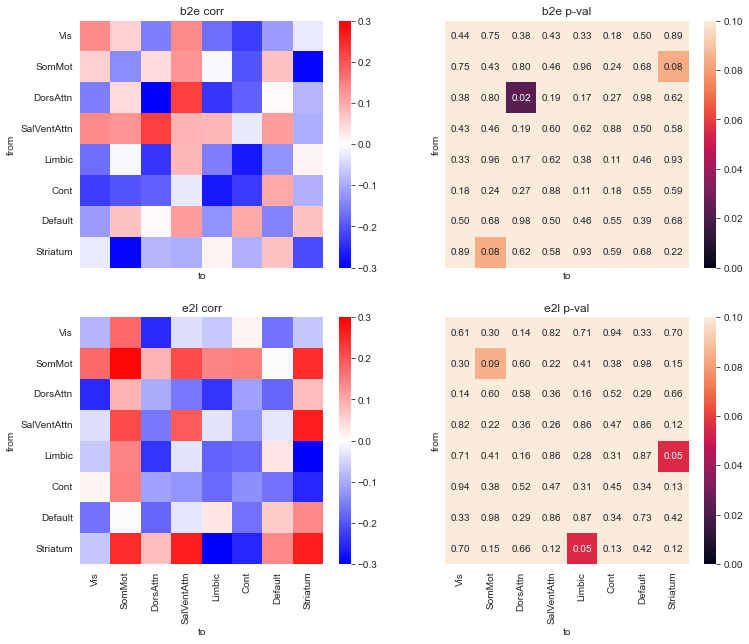

In [236]:
# side by side plots. b2e e2l by r and p value

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for i, epoch in enumerate(['b2e', 'e2l']):
    data = corr_scores_r.loc[epoch]
    data = data.unstack('to').loc[names_7net, names_7net]
    seaborn.heatmap(data, cmap='bwr', center=0, vmin=-0.3, vmax=0.3, ax=axes[i, 0])
    axes[i, 0].set_title(epoch + ' corr')

    data = corr_scores_p.loc[epoch]
    data = data.unstack('to').loc[names_7net, names_7net]
    seaborn.heatmap(data, vmax=0.1, vmin=0, ax=axes[i, 1], annot=True, fmt='.2f')
    axes[i, 1].set_title(epoch + ' p-val')

    # plt.savefig('heatmap-corr.svg', format='svg')
    # plt.savefig('heatmap-corr.png')
plt.show()